In [149]:
import dataclasses
import numpy as np
from matplotlib.pyplot import figure

def norm(v):
    return np.sqrt(np.sum(v**2))

class Dioptre:
    def _shift(self, d):
        param = dataclasses.asdict(self)
        param['position'] += d
        return SphericalDioptre(**param)

    def __add__(self, other):
        return OpticalSystem([self]) + other
        

@dataclasses.dataclass
class SphericalDioptre(Dioptre):
    position : float
    radius_of_curvature : float
    refractive_index : tuple
    diameter : float = 25.4
        
    def _reverse(self, new_index):
        param = dataclasses.asdict(self)
        param['position'] *= -1
        param['radius_of_curvature'] *= -1
        param['refractive_index'] = new_index
        return SphericalDioptre(**param)

        
    @property
    def center(self):
        return self.position + self.radius_of_curvature
    
    def shape(self, z):
        return self.center - np.sign(self.radius_of_curvature)*np.sqrt(self.radius_of_curvature**2 - z**2)
    
    def plot(self, ax):
        z = np.linspace(-self.diameter/2, self.diameter/2, 201)
        ax.plot(self.shape(z), z)
        
    def get_refracted_ray(self, incident_ray):
        intersection_point = self.intersection(incident_ray)
        n = intersection_point - np.array([self.center, 0])
        n = n/norm(n)
        k_par = incident_ray.direction_k - np.sum(incident_ray.direction_k*n)*n
        k_r_perp = np.sqrt(self.refractive_index**2 - norm(k_par)**2) * n
        return Ray(intersection_point, k_par - np.sign(self.radius_of_curvature)*k_r_perp)
        
    
    def intersection(self, incident_ray):
        alpha = np.sum(incident_ray.direction_k**2)
        d = (incident_ray.starting_point - np.array([self.center, 0]))
        beta = 2*np.sum(incident_ray.direction_k * d)
        gamma = np.sum(d**2) - self.radius_of_curvature**2
        
        t = (-beta - np.sign(self.radius_of_curvature) * np.sqrt(beta**2 - 4*alpha*gamma))/(2*alpha)
        return incident_ray.starting_point + t*incident_ray.direction_k

@dataclasses.dataclass
class Screen(Dioptre):
    position : float
    diameter : float = 25.4

    def get_refracted_ray(self, incident_ray):
        intersection_point = self.intersection(incident_ray)
        return Ray(intersection_point, incident_ray.direction_k)
        
    
    def intersection(self, incident_ray):
        distance = self.position - incident_ray.starting_point[0]
        t = distance/incident_ray.direction_k[0]
        return incident_ray.starting_point + t*incident_ray.direction_k
    
    def plot(self, ax):
        ax.plot([self.position, self.position], [-self.diameter/2, self.diameter/2])
    
    
class Ray:
    def __init__(self, starting_point, direction_k, refractive_index=None):
        self.starting_point = np.array(starting_point)
        self.direction_k = np.array(direction_k)
        self.refractive_index = refractive_index
        if self.refractive_index is not None:
            self.normalize_direction_to_refractive_index()
        
    def normalize_direction_to_refractive_index(self):
        norm_k = norm(self.direction_k)
        self.direction_k = self.direction_k/norm_k*self.refractive_index
        
    def __repr__(self):
        return f'Ray({self.starting_point!s}, {self.direction_k!s})'
    
class OpticalSystem:
    def __init__(self, list_of_dioptre=None):
        if list_of_dioptre is None:
            list_of_dioptre = []
        self.list_of_dioptre = list_of_dioptre
        
    def append(self, dioptre):
        self.list_of_dioptre.append(dioptre)
        
    def plot(self, ax):
        for dioptre in self.list_of_dioptre:
            dioptre.plot(ax)
            
    def ray_tracing(self, incident_ray):
        out = [incident_ray]
        for dioptre in self.list_of_dioptre:
            incident_ray = dioptre.get_refracted_ray(incident_ray)
            out.append(incident_ray)
        return RayList(out)
            
    def __matmul__(self, d):
        return OpticalSystem([dioptre._shift(d) for dioptre in self.list_of_dioptre])
    
    def __neg__(self):
        index = [dioptre.refractive_index for dioptre in self.list_of_dioptre]
        new_index = index[:-1][::-1] + [index[-1]]
        out = []
        for dioptre, new_index in zip(self.list_of_dioptre[::-1], new_index):
            out.append(dioptre._reverse(new_index))
        return OpticalSystem(out)
    
    def __repr__(self):
        return f'OpticalSystem({self.list_of_dioptre})'
    
    def __add__(self, other):
        if isinstance(other, Dioptre):
            other = OpticalSystem([other])
        if isinstance(other, OpticalSystem):
            return OpticalSystem(self.list_of_dioptre + other.list_of_dioptre)
        return NotImplemented
        
class RayList:
    def __init__(self, list_of_ray=None):
        if list_of_ray is None:
            list_of_ray = []
        self.list_of_ray = list_of_ray
        
    def append(self, ray):
        self.list_of_ray.append(ray)
        
    def plot(self, ax):
        X = [dioptre.starting_point[0] for dioptre in self.list_of_ray]
        Z = [dioptre.starting_point[1] for dioptre in self.list_of_ray]
        ax.plot(X, Z)
        
    def __repr__(self):
        return f'Raylist({self.list_of_ray})'


In [150]:
import unittest

class TestNotebook(unittest.TestCase):
    
    def test_dioptre(self):
        dioptre = SphericalDioptre(5, 100, 1.01)
        self.assertEqual(dioptre.shape(0), 5)
        
        
    def test_ray(self):
        r = Ray((0, 0), (1, .1), 1)
        self.assertLess(r.direction_k[0], 1)
        
    def test_intersection(self):
        dioptre = SphericalDioptre(5, 100, 1.1)
        r = Ray((0, 0), (1, .1), 1)
        x, z = dioptre.intersection(r)

        self.assertLess(x, 6)
        
        out_ray = dioptre.get_refracted_ray(r)
        self.assertGreater(out_ray.direction_k[0], 1)
        
    def test_screen(self):
        screen = Screen(5)
        r = Ray((0, 0), (1, .1), 1)
        out_ray = screen.get_refracted_ray(r)
        self.assertEqual(out_ray.starting_point[0], 5)

        
        
unittest.main(argv=[''], verbosity=1, exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.002s

OK


In [151]:
n_LAH64 = 1.77694
n_SF11 = 1.76583
n_BK7 = 1.5112
n_air = 1.0002992

#Reference from https://www.thorlabs.com/
s1 = SphericalDioptre(0, -4.7 , n_SF11, diameter=3)
s2 = SphericalDioptre(1.5, 1E10, n_air, diameter=3)

LC2969 = OpticalSystem([s1, s2]) # Return an OpticalSystem
s1 = SphericalDioptre(0, 1E10 ,  n_BK7)
s2 = SphericalDioptre(4.1, -38.6, n_air)

LA1608 = OpticalSystem([s1, s2]) # Return an OpticalSystem
system = -LC2969 + LA1608@50 + Screen(70)




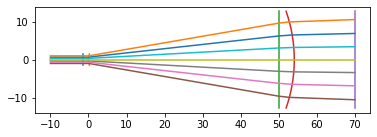

In [152]:
fig = figure()
ax = fig.subplots(1, 1)
ax.set_aspect(1)

system.plot(ax)
for h in np.linspace(-1, 1, 7):
    r = Ray((-10, h), (1, 0))
    system.ray_tracing(r).plot(ax)